# **<font color='yellow'>Handling data quality issues in a time-series: Fuel LBP rates:</font>**

## *<font color='orange'>Data set:</font>*

The data set is a comma-separated values (CSV) file that contains the evolution of the fuel prices in Lebanon from 11-8-2021 till 5-9-2023 collected from the Lira Rate website.<br>We ignored the values before 11-08-2021, as this is the date of the removal of fuel subsidies by the Lebanese government.<br>


**• DateTime:** The timestamp<br>
**• OCTANE 95 (LBP)**<br>
**• OCTANE 98 (LBP)**<br>
**• DIESEL (LBP)**<br>
**• GAS (LBP)**<br>
**• BRENT CRUDE OIL (USD)**<br>
**• USD to LBP:** The market rate of the Lebanese Lira compared to 1 USD.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data1=pd.read_csv('fuel-LBP-rates (2).csv')
data1.head(3)

,DateTime,OCTANE 95 (LBP),OCTANE 98 (LBP),DIESEL (LBP),GAS (LBP),BRENT CRUDE OIL (USD),USD to LBP
0,8/11/2021 09:19,NaN,NaN,NaN,NaN,NaN,20575.0
1,8/11/2021 11:32,NaN,NaN,NaN,NaN,NaN,20500.0
2,8/11/2021 13:55,NaN,NaN,NaN,NaN,NaN,20550.0


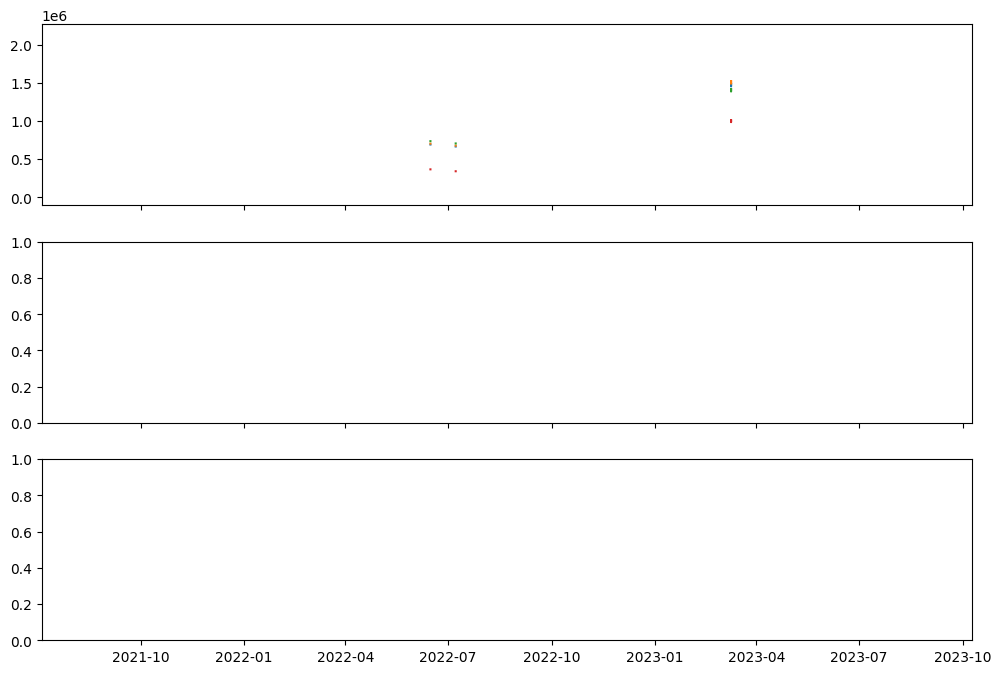

In [9]:
# Creating the figure for all subplots:
fig, axes= plt.subplots(nrows=3,ncols=1,figsize=(12,8),sharex=True)
# converting the datetime column into datetime format:
datetime1=pd.to_datetime(data1['DateTime'])
# Creating a loop to plot the lebanese fuel prices with the 2nd, 3rd,4th and 5th columns:
lbp_columns = data1.columns[1:5] 
for column in lbp_columns:
     axes[0].plot(datetime1, data1[column], label=column)